
## Import libraries and reading data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
import nltk
import warnings
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
warnings.filterwarnings('ignore')

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_parquet('aita_combine.parquet', engine='pyarrow')
df

,id,timestamp,title,body,edited,verdict,score,num_comments
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,False,asshole,52,13.0
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",1393290576.0,asshole,140,27.0
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,False,not the asshole,74,15.0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,1393286962.0,everyone sucks,22,3.0
4,1yueqb,1.393288e+09,[AITA] I let my story get a little long and bo...,None,False,not the asshole,6,4.0
...,...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...",False,No A-holes here,1,17.0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,False,Not the A-hole,0,6.0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...",False,No A-holes here,0,4.0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,False,Everyone Sucks,3,9.0


In [7]:
# processing label attribute.
df['verdict'].value_counts()

verdict
not the asshole                   59114
Not the A-hole                    37323
asshole                           20959
no assholes here                  12003
Asshole                           11069
everyone sucks                     5552
No A-holes here                    3286
Everyone Sucks                     2205
Not enough info                     979
UPDATE                              647
TL;DR                               191
META                                181
Best of 2022                          9
Open Forum                            8
Announcement                          2
Best of 2021                          2
Misleading Title Hall of Shame        1
Upcoming Talk!!!                      1
Name: count, dtype: int64

In [8]:
#check unique values in verdict attribute
unique_values = df['verdict'].unique()
print(unique_values)

['asshole' 'not the asshole' 'everyone sucks' 'no assholes here' 'Asshole'
 'Not the A-hole' 'Not enough info' 'META' 'No A-holes here'
 'Everyone Sucks' 'UPDATE' 'TL;DR' None 'Announcement'
 'Misleading Title Hall of Shame' 'Best of 2021' 'Open Forum'
 'Best of 2022' 'Upcoming Talk!!!']


In [9]:
# remove unecessary values in label attribute
values_to_keep = ['asshole', 'not the asshole', 'everyone sucks', 'no assholes here', 'Asshole', 'Not the A-hole','No A-holes here', 'Everyone Sucks']
df = df.drop(df[~df['verdict'].isin(values_to_keep)].index)
unique_values = df['verdict'].unique()
print(unique_values)

['asshole' 'not the asshole' 'everyone sucks' 'no assholes here' 'Asshole'
 'Not the A-hole' 'No A-holes here' 'Everyone Sucks']


In [10]:
# merge the the same meaning values in label
df['verdict'] = df['verdict'].replace({
    'Asshole': 'asshole',
    'Not the A-hole': 'not the asshole',
    'Everyone Sucks': 'everyone sucks',
    'No A-holes here': 'no assholes here'})

unique_values = df['verdict'].unique()
print(unique_values)

['asshole' 'not the asshole' 'everyone sucks' 'no assholes here']


In [11]:
# transfer the label values to two classes 0:not_asshole, 1:is_asshole
df['is_asshole'] = df['verdict'].map({'asshole': 1, 'not the asshole': 0, 'everyone sucks': 1, 'no assholes here': 0})
df

,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,False,asshole,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",1393290576.0,asshole,140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,False,not the asshole,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,1393286962.0,everyone sucks,22,3.0,1
4,1yueqb,1.393288e+09,[AITA] I let my story get a little long and bo...,None,False,not the asshole,6,4.0,0
...,...,...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...",False,no assholes here,1,17.0,0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,False,not the asshole,0,6.0,0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...",False,no assholes here,0,4.0,0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,False,everyone sucks,3,9.0,1


## EDA (EXPLORATORY DATA ANALYSIS)

In [12]:
df

,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,False,asshole,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",1393290576.0,asshole,140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,False,not the asshole,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,1393286962.0,everyone sucks,22,3.0,1
4,1yueqb,1.393288e+09,[AITA] I let my story get a little long and bo...,None,False,not the asshole,6,4.0,0
...,...,...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...",False,no assholes here,1,17.0,0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,False,not the asshole,0,6.0,0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...",False,no assholes here,0,4.0,0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,False,everyone sucks,3,9.0,1


In [13]:
# check columns and rows
df.shape

(151511, 9)

In [14]:
# check info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151511 entries, 0 to 153690
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            151511 non-null  object 
 1   timestamp     151511 non-null  float64
 2   title         151511 non-null  object 
 3   body          151421 non-null  object 
 4   edited        151511 non-null  object 
 5   verdict       151511 non-null  object 
 6   score         151511 non-null  int64  
 7   num_comments  151511 non-null  float64
 8   is_asshole    151511 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 11.6+ MB


In [15]:
# check null values
df.isna().sum()

id               0
timestamp        0
title            0
body            90
edited           0
verdict          0
score            0
num_comments     0
is_asshole       0
dtype: int64

In [16]:
# check duplicate values and find the unusual.
duplicate_counts = df.apply(lambda x: x.duplicated().sum())
# Display the duplicate counts
print("Duplicate counts for each attribute:")
print(duplicate_counts)

Duplicate counts for each attribute:
id                 148
timestamp          352
title             1649
body               491
edited          119138
verdict         151507
score           140115
num_comments    147659
is_asshole      151509
dtype: int64


In [17]:
#why'num_comments','score','adjudicaion' cause a large duplication?
print(df['num_comments'].nunique())
print(df['score'].nunique())
print(df['is_asshole'].nunique())

3852
11396
2


<Axes: ylabel='verdict'>

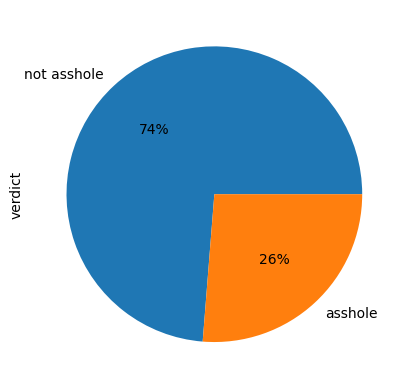

In [18]:
# Pie chart
df['is_asshole'].value_counts().plot(kind='pie',  autopct='%1.0f%%', ylabel='verdict', labels=["not asshole", "asshole"])

## PREPROCESSING


In [19]:
# remove the unnecessary attributes
column_name_to_remove = ['verdict', 'edited']
df = df.drop(column_name_to_remove, axis=1)
print("-"*30 +"update now" + "-"*30)
print(df.shape)
df


------------------------------update now------------------------------
(151511, 7)


,id,timestamp,title,body,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,22,3.0,1
4,1yueqb,1.393288e+09,[AITA] I let my story get a little long and bo...,None,6,4.0,0
...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...",1,17.0,0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,0,6.0,0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...",0,4.0,0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,3,9.0,1


In [20]:
# number of missing values
print("Before:")
print(df.isna().sum())

Before:
id               0
timestamp        0
title            0
body            90
score            0
num_comments     0
is_asshole       0
dtype: int64


In [21]:
# remove missing values
print("After:")
df = df.dropna()
print(df.isna().sum())
print("-"*30 +"update now" + "-"*30)
print(df.shape)

After:
id              0
timestamp       0
title           0
body            0
score           0
num_comments    0
is_asshole      0
dtype: int64
------------------------------update now------------------------------
(151421, 7)


In [22]:
#Duplicate 'body' column
df.insert(df.columns.get_loc('body'), 'body_original', df['body'])
df

,id,timestamp,title,body_original,body,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,[Here is the post in question](http://www.redd...,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...","My parents are diabetic, morbidly obese, and a...",140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,I was four.,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,22,3.0,1
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,I love the musical *Les Miserables*. A coworke...,22,15.0,1
...,...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...","I might be the asshole here, but I want extern...",1,17.0,0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,I'm 17 F and my bf lives far away from me and...,0,6.0,0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...","just for some background, I 14m, have always h...",0,4.0,0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,I'm 36 he (let's call him df) is 42. We met an...,3,9.0,1


In [23]:
# remove duplicate values in id
columns_name = ['id']
# Remove duplicates in the specified column
df = df.drop_duplicates(subset=columns_name)

duplicate_counts = df.apply(lambda x: x.duplicated().sum())
# Display the duplicate counts
print("Duplicate counts for each attribute:")
print(duplicate_counts)

print("-"*30 +"update now" + "-"*30)
print(df.shape)

Duplicate counts for each attribute:
id                    0
timestamp           204
title              1502
body_original       318
body                318
score            139883
num_comments     147422
is_asshole       151271
dtype: int64
------------------------------update now------------------------------
(151273, 8)


In [24]:
# remove duplicate values in body
columns_name = ['body']
# Remove duplicates in the specified column
df = df.drop_duplicates(subset=columns_name)

duplicate_counts = df.apply(lambda x: x.duplicated().sum())
# Display the duplicate counts
print("Duplicate counts for each attribute:")
print(duplicate_counts)

print("-"*30 +"update now" + "-"*30)
print(df.shape)

Duplicate counts for each attribute:
id                    0
timestamp           199
title              1488
body_original         0
body                  0
score            139576
num_comments     147109
is_asshole       150953
dtype: int64
------------------------------update now------------------------------
(150955, 8)


In [25]:
# find the rows that contains *deleted* in its value
column_name = 'body'
# Use boolean indexing to filter rows where the specified column has the value '[deleted]'
contains_deleted_body = df[df[column_name].str.contains('deleted')]
shortest_rows = df.loc[contains_deleted_body[column_name].str.len().nsmallest(50).index]
shortest_rows


,id,timestamp,title,body_original,body,score,num_comments,is_asshole
61554,d1wx0e,1.568062e+09,WIBTA if I used the “slow fade” to this “friend”?,deleted,deleted,3,4.0,0
41222,c5kvm0,1.561522e+09,WIBTA if I kept a laptop someone left in the s...,\[deleted\],\[deleted\],4,24.0,1
80543,e48p9m,1.575168e+09,AITA; Adult stepchild living at home,\*deleted\*,\*deleted\*,12,46.0,1
102553,f3yrqa,1.581714e+09,AITA for giving money to underprivileged kids ...,*deleted for privacy issues,*deleted for privacy issues,0,32.0,0
96534,evabws,1.580240e+09,AITA For not wanting to pick my mom and her bo...,"Hey guys, I posted on here like two days ago a...","Hey guys, I posted on here like two days ago a...",22,11.0,0
10551,agqqkg,1.547678e+09,AITA for being doubtful that someone accidenta...,Context: person sent porn to a server that doe...,Context: person sent porn to a server that doe...,6,9.0,1
751,4ebmcl,1.460394e+09,AITA for deleting my ex off my social media?,She called me and broke up with me at work wit...,She called me and broke up with me at work wit...,17,10.0,0
93327,epn4sl,1.579198e+09,AITA for not wanting to “improve” myself?,I’m making this post for a friend who worries ...,I’m making this post for a friend who worries ...,127,137.0,0
98701,eytphl,1.580838e+09,AITA for not wanting my sister to yell at me i...,edit- i deleted it in case my sister some how ...,edit- i deleted it in case my sister some how ...,1,13.0,1
5111,9tl8ff,1.541173e+09,AITA for not driving my co-worker to lunch eve...,This post is deleted this post is deleted this...,This post is deleted this post is deleted this...,239,80.0,0


In [26]:
#remove 100 shortest nonsense bodies that contain "delete"
# Remove rows with specified indices
df = df.drop(shortest_rows.index)
df

,id,timestamp,title,body_original,body,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,[Here is the post in question](http://www.redd...,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...","My parents are diabetic, morbidly obese, and a...",140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,I was four.,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,22,3.0,1
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,I love the musical *Les Miserables*. A coworke...,22,15.0,1
...,...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...","I might be the asshole here, but I want extern...",1,17.0,0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,I'm 17 F and my bf lives far away from me and...,0,6.0,0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...","just for some background, I 14m, have always h...",0,4.0,0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,I'm 36 he (let's call him df) is 42. We met an...,3,9.0,1


In [27]:
# find the rows that contain *remove* in its value
column_name = 'body'
# Use boolean indexing to filter rows where the specified column has the value '[deleted]'
contains_remove_body = df[df[column_name].str.contains('remove')]
shortest_rows_remove = df.loc[contains_remove_body[column_name].str.len().nsmallest(50).index]
shortest_rows_remove

,id,timestamp,title,body_original,body,score,num_comments,is_asshole
68083,deytxe,1.570535e+09,AITA for being upset with my friend for not be...,removed,removed,10,8.0,0
97722,exee0w,1.580599e+09,AITA for stopping to check out a yoga studio?,[removed],[removed],0,54.0,1
84380,eb5rhm,1.576449e+09,WIBTA for proposing on New Year's?,\[removed\],\[removed\],348,239.0,0
77551,dxtbjv,1.574028e+09,WIBTA if I reported an autistic student for co...,"removed because the issue has been dealt with,...","removed because the issue has been dealt with,...",171,79.0,0
7750,a5si88,1.544699e+09,AITA For asking a female friend to crop me out...,She made her profile picture one of the two of...,She made her profile picture one of the two of...,6,16.0,0
19347,b241bn,1.552820e+09,WIBTA if i call cops on a busker?,Im working weekends on an town square. Every w...,Im working weekends on an town square. Every w...,35,42.0,1
100139,f0u2ab,1.581180e+09,AITA for changing password for a Netflix subsc...,I had to change the password because Netflix t...,I had to change the password because Netflix t...,87,17.0,0
5879,9x6dxe,1.542245e+09,AITA for not letting my guy friends spank me?,I'm a dude and a bunch of my guy friends at a ...,I'm a dude and a bunch of my guy friends at a ...,40,23.0,0
89811,ejm027,1.578087e+09,AITA for costing my friend his Starbound saves?,My friend is pissed at me.\n\nHe's upset becau...,My friend is pissed at me.\n\nHe's upset becau...,3,7.0,0
92038,enhonf,1.578797e+09,AITA for telling my employee that she couldn't...,"I'm a small business CEO, with a team of 40 pe...","I'm a small business CEO, with a team of 40 pe...",147,39.0,0


In [28]:
# remove 50 shortest nonsense bodies that contain "remove"
# Remove rows with specified indices
df = df.drop(shortest_rows_remove.index)
df

,id,timestamp,title,body_original,body,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,[Here is the post in question](http://www.redd...,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...","My parents are diabetic, morbidly obese, and a...",140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,I was four.,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,22,3.0,1
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,I love the musical *Les Miserables*. A coworke...,22,15.0,1
...,...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...","I might be the asshole here, but I want extern...",1,17.0,0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,I'm 17 F and my bf lives far away from me and...,0,6.0,0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...","just for some background, I 14m, have always h...",0,4.0,0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,I'm 36 he (let's call him df) is 42. We met an...,3,9.0,1


In [29]:
# create a copy dataset from df
df_copy = df.copy()
print("-"*30 +"update now" + "-"*30)
df_copy

------------------------------update now------------------------------


,id,timestamp,title,body_original,body,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,[Here is the post in question](http://www.redd...,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...","My parents are diabetic, morbidly obese, and a...",140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,I was four.,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,22,3.0,1
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,I love the musical *Les Miserables*. A coworke...,22,15.0,1
...,...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...","I might be the asshole here, but I want extern...",1,17.0,0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,I'm 17 F and my bf lives far away from me and...,0,6.0,0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...","just for some background, I 14m, have always h...",0,4.0,0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,I'm 36 he (let's call him df) is 42. We met an...,3,9.0,1


In [30]:
# remove emoji in bodies
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df_copy['body'] = df['body'].apply(lambda x: remove_emoji(x))
df_copy


,id,timestamp,title,body_original,body,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,[Here is the post in question](http://www.redd...,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...","My parents are diabetic, morbidly obese, and a...",140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,I was four.,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,22,3.0,1
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,I love the musical *Les Miserables*. A coworke...,22,15.0,1
...,...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...","I might be the asshole here, but I want extern...",1,17.0,0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,I'm 17 F and my bf lives far away from me and...,0,6.0,0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...","just for some background, I 14m, have always h...",0,4.0,0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,I'm 36 he (let's call him df) is 42. We met an...,3,9.0,1


In [31]:
# remove hyperlink
# Function to remove hyperlinks using regular expression
def remove_hyperlinks(text):
    return re.sub(r'http[s]?://\S+|www\.\S+', '', text)

# Apply the function to the 'text_column'
df_copy['body'] = df_copy['body'].apply(remove_hyperlinks)
df_copy.head(10)

,id,timestamp,title,body_original,body,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,[Here is the post in question](\n\nIt seems li...,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...","My parents are diabetic, morbidly obese, and a...",140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,I was four.,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,\n\n,22,3.0,1
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,I love the musical *Les Miserables*. A coworke...,22,15.0,1
6,1yux10,1.393298e+09,[ATIA] I permanently give a customer decaf.,His name is Scoop. \n\nOver the two years I ha...,His name is Scoop. \n\nOver the two years I ha...,12,14.0,1
7,1yvb3n,1.393307e+09,[AITA] My roommate has many undesirable qualit...,I'm a college student. My first roommate dropp...,I'm a college student. My first roommate dropp...,3,4.0,1
8,1yvd1v,1.393309e+09,[AITA] Hockey Fan,I went to a hockey game at my college and sinc...,I went to a hockey game at my college and sinc...,3,3.0,0
9,1yvl8z,1.393316e+09,[AITA] Door to door sales person,Door to door sales person came to my door arou...,Door to door sales person came to my door arou...,22,20.0,0
10,1yw0t4,1.393335e+09,"[AITA] Gave my friend some peanuts, asked for ...",I was in France this summer with two of my fri...,I was in France this summer with two of my fri...,14,18.0,1


In [32]:
# removal of backslashes and newline characters, conversion to lowercase, and normalization of single quotes.
df_copy['body'] = df_copy['body'].apply(lambda text: text.replace("\\", "").replace("\n", "").lower().replace("\'", "'"))
df_copy.head(10)

,id,timestamp,title,body_original,body,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,[here is the post in question](it seems like i...,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...","my parents are diabetic, morbidly obese, and a...",140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,i was four.,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,,22,3.0,1
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,i love the musical *les miserables*. a coworke...,22,15.0,1
6,1yux10,1.393298e+09,[ATIA] I permanently give a customer decaf.,His name is Scoop. \n\nOver the two years I ha...,his name is scoop. over the two years i have w...,12,14.0,1
7,1yvb3n,1.393307e+09,[AITA] My roommate has many undesirable qualit...,I'm a college student. My first roommate dropp...,i'm a college student. my first roommate dropp...,3,4.0,1
8,1yvd1v,1.393309e+09,[AITA] Hockey Fan,I went to a hockey game at my college and sinc...,i went to a hockey game at my college and sinc...,3,3.0,0
9,1yvl8z,1.393316e+09,[AITA] Door to door sales person,Door to door sales person came to my door arou...,door to door sales person came to my door arou...,22,20.0,0
10,1yw0t4,1.393335e+09,"[AITA] Gave my friend some peanuts, asked for ...",I was in France this summer with two of my fri...,i was in france this summer with two of my fri...,14,18.0,1


In [33]:
# remove unique characters.
df_copy['body'] = df_copy['body'].str.replace('[^\w\s]','')
df_copy.head(10)

,id,timestamp,title,body_original,body,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,[here is the post in question](it seems like i...,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...","my parents are diabetic, morbidly obese, and a...",140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,i was four.,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,,22,3.0,1
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,i love the musical *les miserables*. a coworke...,22,15.0,1
6,1yux10,1.393298e+09,[ATIA] I permanently give a customer decaf.,His name is Scoop. \n\nOver the two years I ha...,his name is scoop. over the two years i have w...,12,14.0,1
7,1yvb3n,1.393307e+09,[AITA] My roommate has many undesirable qualit...,I'm a college student. My first roommate dropp...,i'm a college student. my first roommate dropp...,3,4.0,1
8,1yvd1v,1.393309e+09,[AITA] Hockey Fan,I went to a hockey game at my college and sinc...,i went to a hockey game at my college and sinc...,3,3.0,0
9,1yvl8z,1.393316e+09,[AITA] Door to door sales person,Door to door sales person came to my door arou...,door to door sales person came to my door arou...,22,20.0,0
10,1yw0t4,1.393335e+09,"[AITA] Gave my friend some peanuts, asked for ...",I was in France this summer with two of my fri...,i was in france this summer with two of my fri...,14,18.0,1


In [34]:
# remove stopwords in bodies
stop = stopwords.words('english')
df_copy['body'] = df_copy['body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_copy

,id,timestamp,title,body_original,body,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,[here post question](it seems like came asshol...,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...","parents diabetic, morbidly obese, addicted foo...",140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,four.,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,,22,3.0,1
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,love musical *les miserables*. coworker mine s...,22,15.0,1
...,...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...","might asshole here, want external advicethat's...",1,17.0,0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,i'm 17 f bf lives far away us 18 parents still...,0,6.0,0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...","background, 14m, always trouble making friends...",0,4.0,0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,i'm 36 (let's call df) 42. met fell love fairl...,3,9.0,1


In [35]:
# Lemmatization

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df_copy["body"] = df_copy["body"].apply(lambda text: lemmatize_words(text))
df_copy

,id,timestamp,title,body_original,body,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,[here post question](it seems like came asshol...,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...","parent diabetic, morbidly obese, addicted food...",140,27.0,1
2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,four.,74,15.0,0
3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,,22,3.0,1
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,love musical *les miserables*. coworker mine s...,22,15.0,1
...,...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...","might asshole here, want external advicethat's...",1,17.0,0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,i'm 17 f bf life far away u 18 parent still in...,0,6.0,0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...","background, 14m, always trouble making friends...",0,4.0,0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,i'm 36 (let's call df) 42. met fell love fairl...,3,9.0,1


In [36]:
#check 100 shortest bodies in the dataset after processing hyperlink, unique character, transfering lowcase...
column_name = 'body'
shortest_rows_df1 = df_copy.loc[df_copy[column_name].str.len().nsmallest(100).index]
shortest_rows_df1.tail(50)

,id,timestamp,title,body_original,body,score,num_comments,is_asshole
116983,fs0lta,1.585607e+09,AITA for not wanting to pay rent to my partner...,Deleted.,deleted.,267,123.0,0
49730,cid2j4,1.564201e+09,AITA for being jealous of my own kids?,[DELETED],[deleted],7,12.0,0
73407,dpfsjt,1.572482e+09,aita for not wanting to pay my friend back for...,jjjjdjciv,jjjjdjciv,25,15.0,0
84073,eant26,1.576350e+09,AITA for asking my neighbor to pay for the fri...,(Deleted),(deleted),3803,1287.0,0
110298,fe7dda,1.583465e+09,AITA for not wanting to drive 5 hours roundtri...,\[REMOVED\],[removed],12,31.0,0
24625,bbkh83,1.554893e+09,AITA for complaining when date is late?,see title.,see title.,4,16.0,0
78607,e01wfh,1.574434e+09,AITA for asking my girlfriend to stop using so...,Been dating this girl for,dating girl,34,127.0,1
111565,ffqvzf,1.583738e+09,WIBTA (my family) for not waiting until my bro...,Thanks all for input,thanks input,21,29.0,0
106640,f9iaco,1.582669e+09,AITA for never attending my MILs bday and Moth...,Changed subs**,changed subs**,4,7.0,1
132478,s8kr7m,1.642690e+09,AITA for a late wedding gift?,Stupid AITA? 🤷‍♀️,stupid aita? 🤷‍,53,58.0,0


In [37]:
#remove 100 shortest bodies because it does not make sense.
df_copy = df_copy.drop(shortest_rows_df1.index)
df_copy

,id,timestamp,title,body_original,body,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,[here post question](it seems like came asshol...,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...","parent diabetic, morbidly obese, addicted food...",140,27.0,1
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,love musical *les miserables*. coworker mine s...,22,15.0,1
6,1yux10,1.393298e+09,[ATIA] I permanently give a customer decaf.,His name is Scoop. \n\nOver the two years I ha...,"name scoop. two year worked coffee shop, told ...",12,14.0,1
7,1yvb3n,1.393307e+09,[AITA] My roommate has many undesirable qualit...,I'm a college student. My first roommate dropp...,i'm college student. first roommate dropped oc...,3,4.0,1
...,...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...","might asshole here, want external advicethat's...",1,17.0,0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,i'm 17 f bf life far away u 18 parent still in...,0,6.0,0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...","background, 14m, always trouble making friends...",0,4.0,0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,i'm 36 (let's call df) 42. met fell love fairl...,3,9.0,1


In [38]:
df_cleaned = df_copy.copy()
df_cleaned

,id,timestamp,title,body_original,body,score,num_comments,is_asshole
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,[here post question](it seems like came asshol...,52,13.0,1
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...","parent diabetic, morbidly obese, addicted food...",140,27.0,1
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,love musical *les miserables*. coworker mine s...,22,15.0,1
6,1yux10,1.393298e+09,[ATIA] I permanently give a customer decaf.,His name is Scoop. \n\nOver the two years I ha...,"name scoop. two year worked coffee shop, told ...",12,14.0,1
7,1yvb3n,1.393307e+09,[AITA] My roommate has many undesirable qualit...,I'm a college student. My first roommate dropp...,i'm college student. first roommate dropped oc...,3,4.0,1
...,...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...","might asshole here, want external advicethat's...",1,17.0,0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,i'm 17 f bf life far away u 18 parent still in...,0,6.0,0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...","background, 14m, always trouble making friends...",0,4.0,0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,i'm 36 (let's call df) 42. met fell love fairl...,3,9.0,1


## Generating features using CountVectorizer:

In [39]:
# Let's generate a BoW matrix for the body
# using scikit-learn's # CountVectorizer:
# Import CountVectorizer and RegexTokenizer
from nltk.tokenize import RegexpTokenizer
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Create Regex tokenizer for removing special symbols and numeric values
regex_tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
# Initialize TfidfVectorizer object
tfidf = TfidfVectorizer(lowercase=True, stop_words
='english',ngram_range = (1,5),tokenizer =
regex_tokenizer.tokenize)
# Fit and transform the dataset
text_tfidf = tfidf.fit_transform(df_cleaned['body'])

## Build model and Evaluate model


In [40]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [41]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [42]:
X = text_tfidf
y = df_cleaned['is_asshole']

### Train Test Split + Resampling

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [44]:
ros = RandomOverSampler()
X_over, y_over = ros.fit_resample(X_train, y_train)

### XGBoost

In [60]:
xgb_clf = XGBClassifier()

start = time.time()
xgb_clf.fit(X_over, y_over)
end = time.time()
xgbElapsedTime = end - start

y_pred = xgb_clf.predict(X_test)

In [61]:
print_score(y_test, y_pred, train=False)

Test Result:
Accuracy Score: 61.06%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.793874     0.340685   0.61056      0.567280      0.675793
recall         0.639336     0.528895   0.61056      0.584116      0.610560
f1-score       0.708273     0.414423   0.61056      0.561348      0.631709
support    22295.000000  7856.000000   0.61056  30151.000000  30151.000000
_______________________________________________
Confusion Matrix: 
 [[14254  8041]
 [ 3701  4155]]



In [62]:
time_dict = {
    'XGBoost': xgbElapsedTime,
}

accuracy_dict = {
    'XGBoost': accuracy_score(y_test, y_pred),
}

### Logistic regrestion model

In [45]:
log_reg = LogisticRegression()

start = time.time()
log_reg.fit(X_over, y_over)
end = time.time()
logregElapsedTime = end - start

y_pred = log_reg.predict(X_test)

In [47]:
print_score(y_test, y_pred, train=False)

Test Result:
Accuracy Score: 71.41%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.772083     0.423989  0.714139      0.598036      0.681386
recall         0.870330     0.270876  0.714139      0.570603      0.714139
f1-score       0.818268     0.330563  0.714139      0.574416      0.691194
support    22295.000000  7856.000000  0.714139  30151.000000  30151.000000
_______________________________________________
Confusion Matrix: 
 [[19404  2891]
 [ 5728  2128]]



In [67]:
time_dict = {
    'Logistic_Regression': logregElapsedTime,
}

accuracy_dict = {
    'Logistic Regression': accuracy_score(y_test, y_pred),
}

### Random Forest

In [68]:
rf_clf = RandomForestClassifier()

start = time.time()
rf_clf.fit(X_over, y_over)
end = time.time()
rfElapsedTime = end - start

y_pred = rf_clf.predict(X_test)

In [69]:
print_score(y_test, y_pred, train=False)

Test Result:
Accuracy Score: 73.69%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.742421     0.427221  0.736891      0.584821      0.660294
recall         0.986410     0.028768  0.736891      0.507589      0.736891
f1-score       0.847198     0.053906  0.736891      0.450552      0.640502
support    22295.000000  7856.000000  0.736891  30151.000000  30151.000000
_______________________________________________
Confusion Matrix: 
 [[21992   303]
 [ 7630   226]]



In [70]:
time_dict = {
    'Random_Forest': rfElapsedTime,
}

accuracy_dict = {
    'Random_Forest': accuracy_score(y_test, y_pred),
}

### KNN model

In [ ]:
print_score(y_test, y_pred, train=False)

## Compare

## Demo

In [47]:
df_backup = df_cleaned.copy()
df_backup['Predicted_Label'] = y_pred
df_backup

,id,timestamp,title,body_original,body,score,num_comments,is_asshole,Predicted_Label
0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,[here post question](it seems like came asshol...,52,13.0,1,0
1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...","parent diabetic, morbidly obese, addicted food...",140,27.0,1,0
5,1yugsc,1.393289e+09,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,love musical *les miserables*. coworker mine s...,22,15.0,1,0
6,1yux10,1.393298e+09,[ATIA] I permanently give a customer decaf.,His name is Scoop. \n\nOver the two years I ha...,"name scoop. two year worked coffee shop, told ...",12,14.0,1,0
7,1yvb3n,1.393307e+09,[AITA] My roommate has many undesirable qualit...,I'm a college student. My first roommate dropp...,i'm college student. first roommate dropped oc...,3,4.0,1,0
...,...,...,...,...,...,...,...,...,...
153686,15pes5u,1.691872e+09,AITA for being annoyed by my family ?,"I might be the asshole here, but I want extern...","might asshole here, want external advicethat's...",1,17.0,0,0
153687,15petd1,1.691872e+09,AITA for changing plans last minute on my boyf...,I'm 17 F and my bf lives far away from me and...,i'm 17 f bf life far away u 18 parent still in...,0,6.0,0,0
153688,15peu49,1.691872e+09,AITA for being upset that my freinds avoid me,"just for some background, I 14m, have always h...","background, 14m, always trouble making friends...",0,4.0,0,0
153689,15peuu4,1.691872e+09,AITA for not wanting my soon to be husband to ...,I'm 36 he (let's call him df) is 42. We met an...,i'm 36 (let's call df) 42. met fell love fairl...,3,9.0,1,0


In [48]:
# show an instance after predicting
title = df_backup.loc[24581, "title"]

body_original = df_backup.loc[24581, "body_original"]

body = df_backup.loc[24581, "body"]

is_asshole = df_backup.loc[24581, "is_asshole"]

predicted_label = df_backup.loc[24581, "Predicted_Label"]


# Displaying the result
print(f"the title is:\n \n{title}")
print("--"*40)
print(f"the original body is:\n \n{body_original}")
print("--"*40)
print(f"the body is:\n \n{body}")
print("--"*40)
print(f"the true_label is:{is_asshole}")
print("--"*40)
print(f"the predicted_label is:{predicted_label}")

the title is:
 
AITA for calling in noise complaints
--------------------------------------------------------------------------------
the original body is:
 
So I live in an apartment complex with thin walls. I can hear everything. I normally don’t mind when it’s like normal living sounds like walking or closing a door, but my upstairs neighbors are absolutely obnoxious. 

Every night between 11 pm and 3 am they bang really loudly on their own doors. I have absolutely no clue why they would do that but the sound of a door being banged on is pretty recognizable. I tried to think if it was something else but the sound couldn’t be anything other than an extremely loud knock. 

Every Saturday morning they have a cook out (hot dogs at 8 am? Not sure why but who am I to judge) they do this right outside my window and blast loud music. I never call in a noise complaint on Saturdays because I couldn’t bear the thought of making their family go back into their house and ruin their fun, so I’d j

## Notes

some knowledge about models:
1. KNN
- for small to moderately sized datasets, the default 'auto' setting often works well. For larger datasets, experimenting with 'ball_tree' or 'kd_tree' might be beneficial. For very small datasets or high-dimensional data, 'brute' might be a reasonable choice.
- 'ball_tree': low-dimension + large size
- 'kd_tree': higher_dimention + large size
- 'brute': high-dimention + small size
- High-dimensional and low-dimensional data refer to the number of features or variables present in a dataset.
- choose the best n_neighbors by variety of methods: Grid Search or Random Search and Plot Accuracy vs. n_neighbors
2. Logistic regression
- solver='lbfgs' is an argument in Logistic regression. It specifies the optimization algorithm to be used for training the logistic regression model. It suits for a large number of variables data and to be efficient in terms of memory usage.
- Choose the best K for F-fold cross validation by: Common Choices for k(not too high or low to balance bias and variance), data size Considerations(large size need to choose small k to optimal performance), use cross_val_score
- bias: using simple model for complex data leading to overfiting phenomenom, it means causing a low accuracy since the model can't capture all featured patterns in the data  
- variace: occasionally, causing by the opposite reason of bias, leading to overfitting with a high accuracy in training-set but a low accuracy in testing-set
- The accuracy_score function in scikit-learn does not have an average argument because accuracy is a single value that represents the overall correctness of predictions and is not computed separately for each class in a multiclass classification problem.
3. SVM
- "liner" kernel, Suitable for high-dimensional data or datasets where the number of features is large compared to the number of samples. For large text datasets, the 'linear' kernel is often a good starting point for computational efficiency.
4. Decision tree